In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Keras 전이학습

In [ ]:
# Step 1: Import Libraries
import pandas as pd
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3
from tensorflow.keras.layers import Input, Average, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# Step 2: Load Images and Label Them
good_images = glob.glob('/content/drive/MyDrive/Colab Notebooks/01.ML/01_cj_project/datasets/img_cls/fm_img_hori/train/good/*.jpg')
ng_images = glob.glob('/content/drive/MyDrive/Colab Notebooks/01.ML/01_cj_project/datasets/img_cls/fm_img_hori/train/ng/*.jpg')

data = pd.DataFrame({
    'path': good_images + ng_images,
    'label': ['good'] * len(good_images) + ['ng'] * len(ng_images)
})

data.head()

,path,label
0,/content/drive/MyDrive/Colab Notebooks/01.ML/0...,good
1,/content/drive/MyDrive/Colab Notebooks/01.ML/0...,good
2,/content/drive/MyDrive/Colab Notebooks/01.ML/0...,good
3,/content/drive/MyDrive/Colab Notebooks/01.ML/0...,good
4,/content/drive/MyDrive/Colab Notebooks/01.ML/0...,good


In [ ]:
# Step 3: Preprocess Images
datagen = ImageDataGenerator(rotation_range=5, shear_range=0.05, validation_split=0.2)
train_data = datagen.flow_from_dataframe(data, x_col='path', y_col='label', target_size=(224, 224),class_mode='binary', subset='training')
val_data = datagen.flow_from_dataframe(data, x_col='path', y_col='label', target_size=(224, 224),class_mode='binary', subset='validation')


Found 736 validated image filenames belonging to 2 classes.
Found 183 validated image filenames belonging to 2 classes.


In [ ]:
#Step 4: Model Building
input_layer = Input(shape=(224, 224, 3))
model1 = InceptionV3(include_top=False, weights='imagenet')(input_layer)
model2 = ResNet50(include_top=False, weights='imagenet')(input_layer)

# Use GlobalAveragePooling to make the shapes compatible
model1_pooled = GlobalAveragePooling2D()(model1)
model2_pooled = GlobalAveragePooling2D()(model2)

average = Average()([model1_pooled, model2_pooled])
output_layer = Dense(1, activation='sigmoid')(average)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 5: Callbacks for Early Stopping and Model Checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
callbacks = [early_stopping, model_checkpoint]

# Step 6: Training the Model
history = model.fit(train_data, epochs=10, batch_size=32, validation_data=val_data, callbacks=callbacks) # Specify val_data

Epoch 1/10
23/23 [==============================] - 347s 11s/step - loss: 0.0221 - accuracy: 0.9986 - val_loss: 1268167.8750 - val_accuracy: 0.4590
Epoch 2/10
23/23 [==============================] - 22s 941ms/step - loss: 6.1681e-07 - accuracy: 1.0000 - val_loss: 239567.7969 - val_accuracy: 0.4590
Epoch 3/10
23/23 [==============================] - 23s 989ms/step - loss: 2.0121e-07 - accuracy: 1.0000 - val_loss: 48366.3438 - val_accuracy: 0.4590
Epoch 4/10
23/23 [==============================] - 22s 949ms/step - loss: 8.0653e-08 - accuracy: 1.0000 - val_loss: 14646.3760 - val_accuracy: 0.4590
Epoch 5/10
23/23 [==============================] - 22s 937ms/step - loss: 8.6575e-08 - accuracy: 1.0000 - val_loss: 5128.4883 - val_accuracy: 0.4590
Epoch 6/10
23/23 [==============================] - 22s 951ms/step - loss: 3.5516e-08 - accuracy: 1.0000 - val_loss: 1867.1700 - val_accuracy: 0.4590
Epoch 7/10
23/23 [==============================] - 22s 949ms/step - loss: 5.0925e-08 - accuracy: 

## 학습그래프

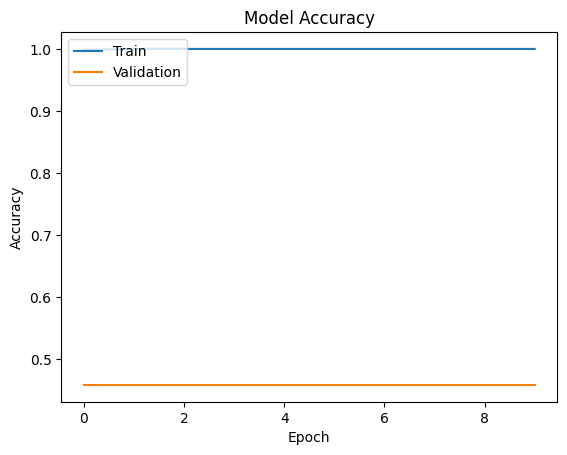

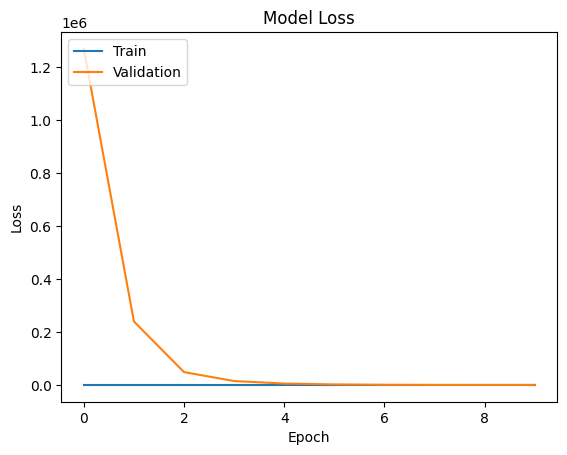

In [ ]:
import matplotlib.pyplot as plt

# Plotting Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plotting Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


1/1 [==============================] - 0s 42ms/step


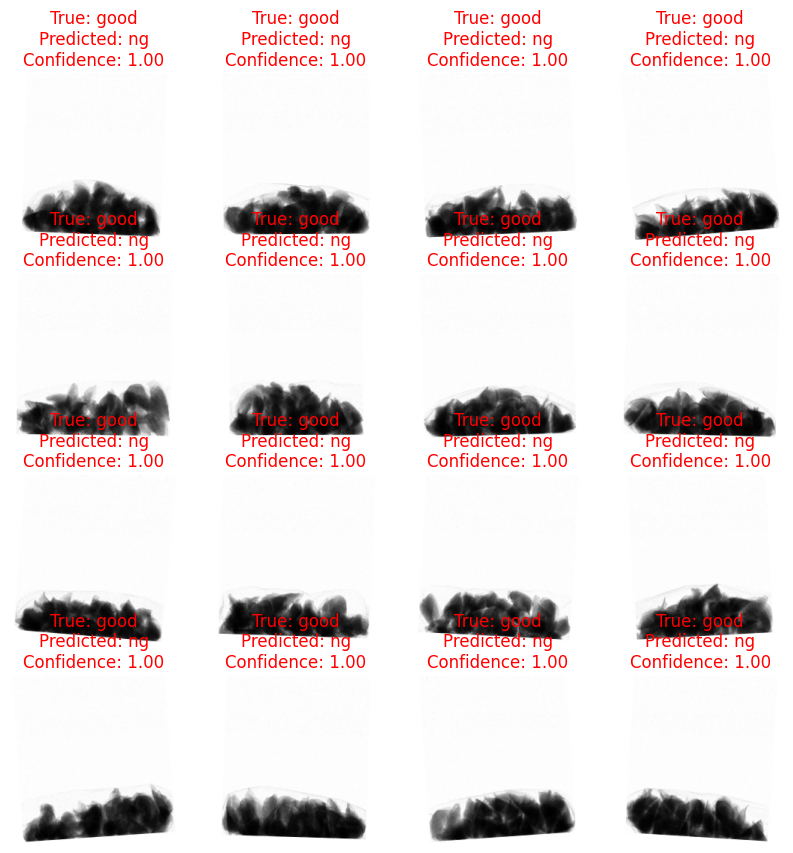

In [ ]:
import random

# Get all the validation images and labels
val_images, val_labels = next(val_data)

# Make predictions on the validation images
predictions = model.predict(val_images)
predictions_labels = (predictions > 0.5).astype('int32')

# Get the true labels
true_labels = val_labels.astype('int32')

# Find incorrect predictions
incorrect_indices = np.where(predictions_labels.flatten() != true_labels.flatten())[0]

# If there are no incorrect predictions, just select random indices
if len(incorrect_indices) == 0:
    selected_indices = random.sample(range(len(val_images)), 16)
else:
    selected_indices = random.sample(list(incorrect_indices), min(16, len(incorrect_indices)))

# Plotting selected predictions
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    idx = selected_indices[i]
    image = val_images[idx]
    image = (image - image.min()) / (image.max() - image.min())  # Normalize to [0, 1]
    ax.imshow(image)
    true_label = "good" if true_labels[idx] == 0 else "ng"
    predicted_label = "good" if predictions_labels[idx] == 0 else "ng"
    confidence = float(predictions[idx])  # Convert to Python scalar
    title = f"True: {true_label}\nPredicted: {predicted_label}\nConfidence: {confidence:.2f}"
    ax.set_title(title, color=('blue' if true_label == predicted_label else 'red'))
    ax.axis('off')

plt.show()


Found 8 images belonging to 2 classes.
1/1 [==============================] - 2s 2s/step - loss: 34.0307 - accuracy: 0.3750
Test Accuracy: 37.50%
Test Loss: 34.0307


In [ ]:
import time
import os

# Define lists to store results
filenames = []
true_labels = []
predicted_labels = []
inference_times = []

# Iterate through the test data
for i in range(len(test_data)):
    batch_images, batch_labels = test_data[i]
    for j in range(len(batch_labels)):
        image = np.expand_dims(batch_images[j], axis=0)
        true_label = batch_labels[j]

        # Measure inference time
        start_time = time.time()
        prediction = model.predict(image)
        inference_time = time.time() - start_time

        # Append results
        filenames.append(os.path.basename(test_data.filenames[i * test_data.batch_size + j]))
        true_labels.append('good' if true_label == 0 else 'ng')
        predicted_labels.append('good' if prediction[0][0] < 0.5 else 'ng')
        inference_times.append(inference_time)

# Create DataFrame
results_df = pd.DataFrame({
    'Filename': filenames,
    'True Label': true_labels,
    'Predicted Label': predicted_labels,
    'Inference Time (seconds)': inference_times
})

# Display DataFrame
results_df


1/1 [==============================] - 0s 32ms/step


,Filename,True Label,Predicted Label,Inference Time (seconds)
0,2022-12-27-150437226.jpg,good,ng,0.091650
1,2022-12-27-150442131.jpg,ng,ng,0.092998
2,2022-12-27-150455831.jpg,good,ng,0.091501
3,2022-12-27-150500626.jpg,ng,ng,0.099687
4,2022-12-27-150505141.jpg,good,ng,0.091274
5,2022-12-27-153800391.jpg,ng,ng,0.087751
6,2022-12-27-153820027.jpg,good,ng,0.093957
7,2022-12-27-160422438.jpg,good,ng,0.092581


#pytorch

In [ ]:
import pandas as pd
import glob
import os
import torch
import torch.nn as nn
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim
from sklearn.model_selection import train_test_split


good_images = glob.glob('/content/drive/MyDrive/Colab Notebooks/01.ML/01_cj_project/datasets/img_cls/fm_img_hori/train/good/*.jpg')
ng_images = glob.glob('/content/drive/MyDrive/Colab Notebooks/01.ML/01_cj_project/datasets/img_cls/fm_img_hori/train/ng/*.jpg')


data = pd.DataFrame({
    'path': good_images + ng_images,
    'label': [0] * len(good_images) + [1] * len(ng_images)
})


class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.dataframe.iloc[idx, 0])
        image = Image.open(img_name)
        label = int(self.dataframe.iloc[idx, 1])

        if self.transform:
            image = self.transform(image)

        return image, label



In [ ]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.RandomRotation(5),
    transforms.RandomAffine(degrees=0, shear=0.05),
    transforms.ToTensor(),
])

train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)
train_dataset = CustomDataset(dataframe=train_data, transform=transform)
val_dataset = CustomDataset(dataframe=val_data, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

class EnsembleModel(nn.Module):
    def __init__(self):
        super(EnsembleModel, self).__init__()
        # self.vgg16 = models.vgg16(pretrained=True)
        self.mobilenet = models.mobilenet_v2(pretrained=True)
        self.resnet50 = models.resnet50(pretrained=True)
        self.fc = nn.Linear(2 * 1000, 1)

    def forward(self, x):
        x1 = self.mobilenet(x)
        x2 = self.resnet50(x)
        x = torch.cat((x1, x2), dim=1)
        x = self.fc(x)
        return torch.sigmoid(x)

In [ ]:
model = EnsembleModel()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3)

best_loss = float('inf')
patience = 0

for epoch in range(10):
    model.train()
    running_loss = 0.0
    print(f"Epoch {epoch + 1}/{10}")
    print('-' * 10)
    for batch_idx, (images, labels) in enumerate(train_loader):
        labels = labels.float().view(-1, 1)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if batch_idx % 10 == 0:
            print(f"Batch {batch_idx}/{len(train_loader)} - Loss: {running_loss / (batch_idx + 1):.4f}")

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            labels = labels.float().view(-1, 1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    scheduler.step(val_loss)

    if val_loss < best_loss:
        best_loss = val_loss
        patience = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience += 1
        if patience > 3:
            print("Early stopping")
            break

    print(f"Epoch {epoch + 1} - Training Loss: {running_loss / len(train_loader):.4f} - Validation Loss: {val_loss:.4f}")
    print()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 70.0MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and

Epoch 1/10
----------
Batch 0/23 - Loss: 0.9076


# Fastai

In [ ]:
from fastai.vision.all import *
from fastai.callback.tracker import SaveModelCallback, EarlyStoppingCallback
from torchvision import models

from sklearn import svm
import numpy as np

In [ ]:
# Step 2: Load Images and Label Them
good_images = glob.glob('/content/drive/MyDrive/Colab Notebooks/01.ML/01_cj_project/datasets/img_cls/fm_img_hori/train/good/*.jpg')
ng_images = glob.glob('/content/drive/MyDrive/Colab Notebooks/01.ML/01_cj_project/datasets/img_cls/fm_img_hori/train/ng/*.jpg')

data_df = pd.DataFrame({
    'path': good_images + ng_images,
    'label': ['good'] * len(good_images) + ['ng'] * len(ng_images)
})

data_df.head()

,path,label
0,/content/drive/MyDrive/Colab Notebooks/01.ML/01_cj_project/datasets/img_cls/fm_img_hori/train/good/2022-12-27-145037611.jpg,good
1,/content/drive/MyDrive/Colab Notebooks/01.ML/01_cj_project/datasets/img_cls/fm_img_hori/train/good/2022-12-27-145353612.jpg,good
2,/content/drive/MyDrive/Colab Notebooks/01.ML/01_cj_project/datasets/img_cls/fm_img_hori/train/good/2022-12-27-145411795.jpg,good
3,/content/drive/MyDrive/Colab Notebooks/01.ML/01_cj_project/datasets/img_cls/fm_img_hori/train/good/2022-12-27-145512015.jpg,good
4,/content/drive/MyDrive/Colab Notebooks/01.ML/01_cj_project/datasets/img_cls/fm_img_hori/train/good/2022-12-27-145115071.jpg,good


In [ ]:
def get_x(r): return r['path']
def get_y(r): return r['label']

dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_x=get_x,
                   get_y=get_y,
                   splitter=RandomSplitter(valid_pct=0.2, seed=42),
                   item_tfms=Resize(224),
                   batch_tfms=aug_transforms(size=224, max_rotate=5, max_warp=0.05))

dls = dblock.dataloaders(data_df, bs=16)


In [ ]:
class EnsembleModel(Module):
    def __init__(self):
        self.mobilenet = models.mobilenet_v2(pretrained=True)
        self.resnet50 = models.resnet50(pretrained=True)

        # Assuming that the last layer's out_features is the same for both models
        num_features = self.mobilenet.classifier[-1].out_features
        self.fc = nn.Linear(num_features, dls.c)  # Replace with the actual number of classes

    def forward(self, x):
        x1 = self.mobilenet(x)
        x2 = self.resnet50(x)
        x = (x1 + x2) / 2
        x = self.fc(x)
        return x

model = EnsembleModel()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 340MB/s]


In [ ]:
# Training with Early Stopping and Model Checkpoint
learn = Learner(dls, model, metrics=accuracy, loss_func=CrossEntropyLossFlat(),
                cbs=[SaveModelCallback(monitor='valid_loss', fname='best_model'),
                     EarlyStoppingCallback(monitor='valid_loss', patience=3)])

learn.fine_tune(10)

epoch,train_loss,valid_loss,accuracy,time
0,0.374019,105.623444,0.885246,01:48


Better model found at epoch 0 with valid_loss value: 105.62344360351562.


epoch,train_loss,valid_loss,accuracy,time
0,0.144523,0.077389,0.972678,00:13
1,0.126833,1.004859,0.513661,00:13
2,0.148543,0.928145,0.885246,00:13
3,0.128236,0.143952,0.950820,00:13


Better model found at epoch 0 with valid_loss value: 0.07738861441612244.
No improvement since epoch 0: early stopping


In [ ]:
from fastai.interpret import ClassificationInterpretation

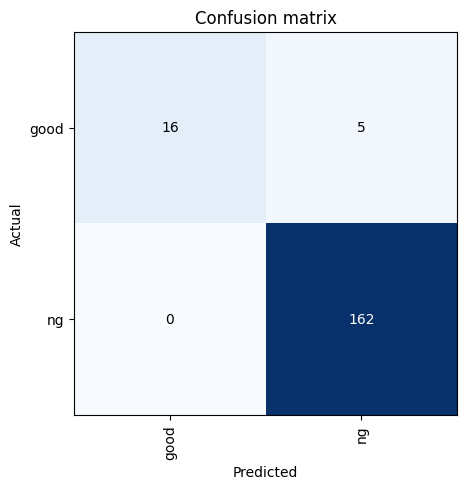

In [ ]:
# 예측값과 실제값 추출
interp = ClassificationInterpretation.from_learner(learn)
preds, targs = interp.top_losses()

interp.plot_confusion_matrix()

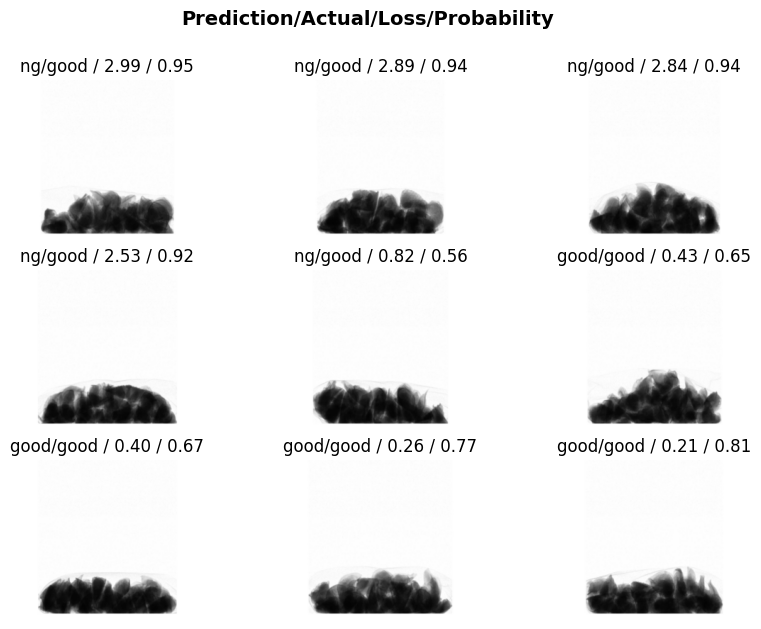

In [ ]:
# 오답 결과 시각화
interp.plot_top_losses(9, figsize=(10,7))

In [ ]:
import time
import pandas as pd

# Load the test images
test_path = '/content/drive/MyDrive/Colab Notebooks/01.ML/01_cj_project/datasets/img_cls/fm_img_hori/test'
test_files = get_image_files(test_path)
test_dls = dls.test_dl(test_files)

# Function to get the label from the file path
def get_label(file_path):
    return 'good' if 'good' in str(file_path) else 'ng'

# List to store the results
results = []

# Iterate over the test files and make predictions
for file in test_files:
    start_time = time.time()
    pred = learn.predict(file)
    inference_time = time.time() - start_time
    label = get_label(file)
    results.append((file.name, label, pred[0], inference_time))

# Convert the results to a DataFrame
results_df = pd.DataFrame(results, columns=['Filename', 'Label', 'Prediction', 'Inference Time'])

# Print the results
results_df

# Optionally, save the results to a CSV file
# results_df.to_csv('/content/test_results.csv', index=False)


,Filename,Label,Prediction,Inference Time
0,2022-12-27-150455831.jpg,good,good,0.834728
1,2022-12-27-150500626.jpg,good,good,0.848945
2,2022-12-27-150442131.jpg,good,good,0.863531
3,2022-12-27-150505141.jpg,good,good,0.885202
4,2022-12-27-150437226.jpg,good,good,0.939304
5,2022-12-27-153800391.jpg,ng,ng,0.947578
6,2022-12-27-153820027.jpg,ng,ng,0.931728
7,2022-12-27-160422438.jpg,ng,ng,0.839940


# fastai anomaly autoencoder

In [5]:
from fastai.vision.all import *
import torch.nn.functional as F

# Define the path to the 'good' folder
path = Path('/content/drive/MyDrive/Colab Notebooks/01.ML/01_cj_project/datasets/img_cls/fm_img_hori/train/good')

# Define a DataBlock for the autoencoder
dblock = DataBlock(
    blocks=(ImageBlock, ImageBlock), # Use ImageBlock for both input and target
    get_items=get_image_files,       # Get image files from the path
    splitter=RandomSplitter(),       # Split data into training and validation sets
    item_tfms=Resize(224)            # Resize images to 224x224
)

# Create DataLoaders from the DataBlock
dls = dblock.dataloaders(path, bs=16)

# Define the Autoencoder model
class Autoencoder(Module):
    def __init__(self):
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1), # Output size: 16 x 112 x 112
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # Output size: 32 x 56 x 56
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # Output size: 16 x 112 x 112
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1), # Output size: 3 x 224 x 224
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Define loss function (reconstruction loss)
def recon_loss(input, target):
    return F.mse_loss(input, target)

# Create Learner
learn = Learner(dls, Autoencoder(), loss_func=recon_loss)

# Train the model
learn.fit_one_cycle(10)


epoch,train_loss,valid_loss,time
0,0.218483,0.217217,00:03
1,0.217524,0.213649,00:02
2,0.215100,0.203946,00:02
3,0.209866,0.182544,00:02
4,0.200035,0.147454,00:02
5,0.185831,0.113049,00:02
6,0.170082,0.090313,00:02
7,0.155291,0.078870,00:02
8,0.142625,0.074710,00:01
9,0.132268,0.074036,00:02


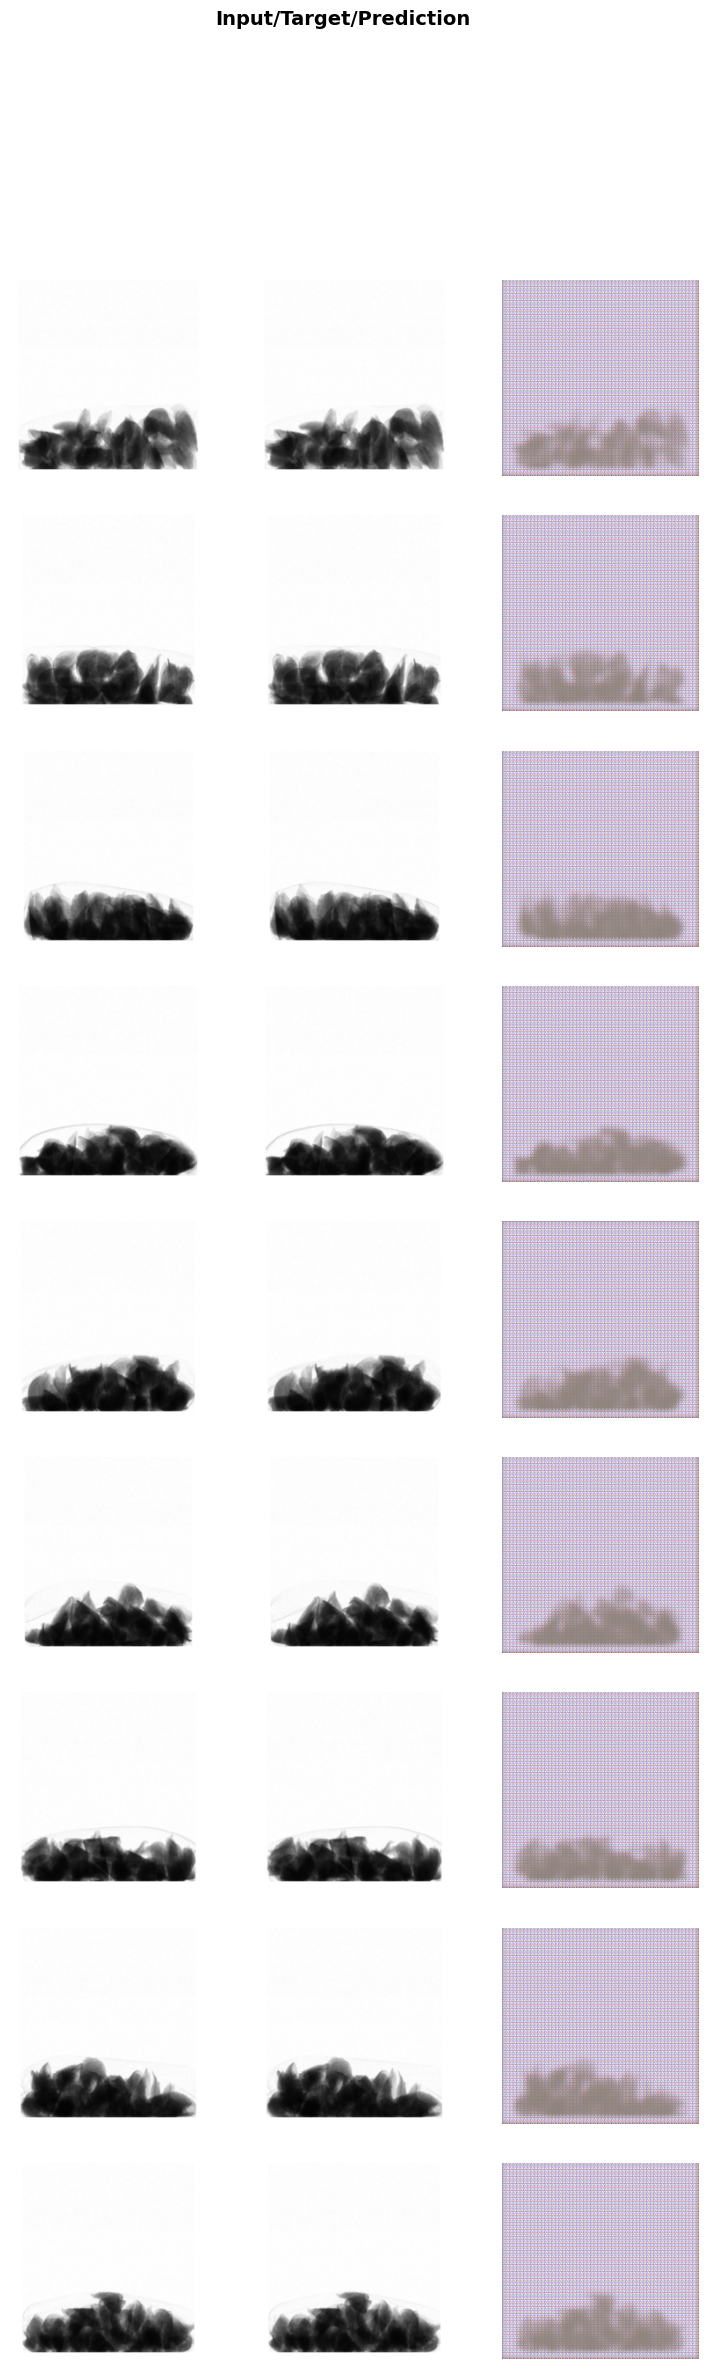

In [6]:
learn.show_results()

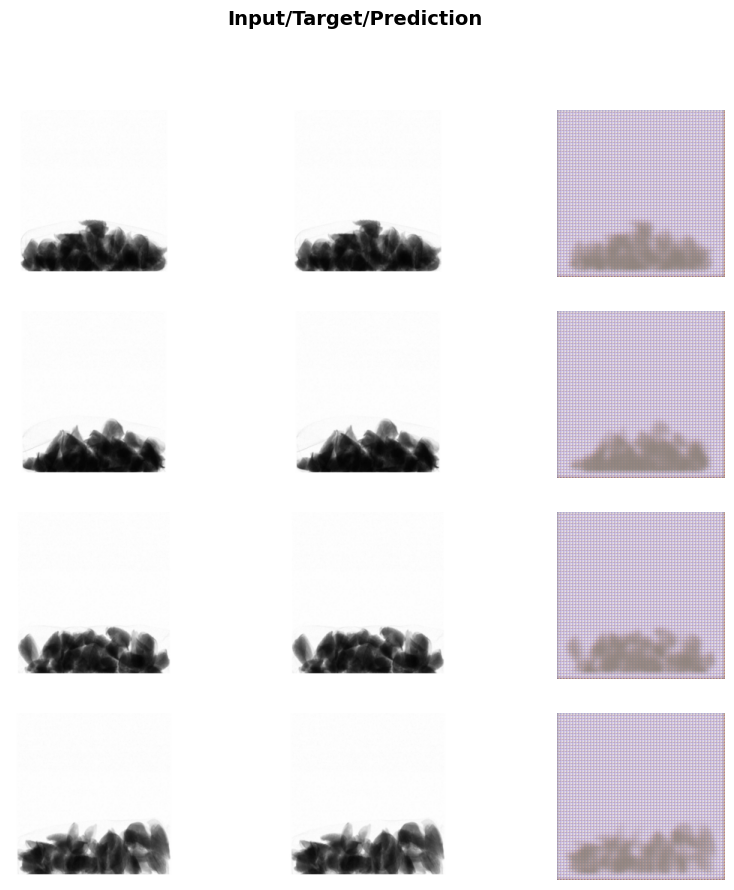

In [7]:
# Show reconstructed images
learn.show_results(max_n=4, figsize=(10,10))


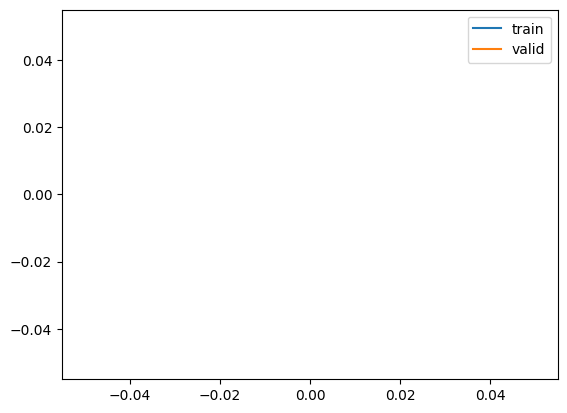

In [8]:
# Plot training and validation losses
learn.recorder.plot_loss()
